## Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import xgboost as xgb
from sklearn.svm import SVC
from scipy.stats import shapiro


C:\Users\Mohamed\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X_train_fname = 'training_templates.csv'
y_train_fname = 'training_labels.txt'
X_test_fname  = 'testing_templates.csv'
X = pd.read_csv(X_train_fname, sep=',', header=None)
X_test  = pd.read_csv(X_test_fname,  sep=',', header=None).values
y = np.loadtxt(y_train_fname, dtype=np.int)

## Critère de performance 

Score entre 0 et 10. Plus le score est petit, mieux c'est 

In [3]:
# Critere de performance
def compute_pred_score(y_true, y_pred):
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score

def challengeScore(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    return 1-compute_pred_score(y_train, clf.predict(X_train))

## Feature Selection 

(105600, 122)
(8496, 122)


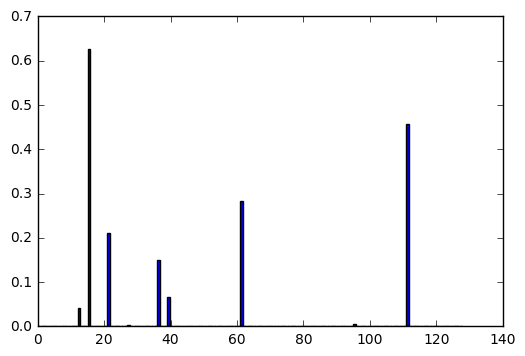

In [4]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFpr
plt.figure()
plt.bar(np.arange(X.shape[1]), f_classif(X,y)[1])
fpr = SelectFpr(f_classif, 0.05)
X = fpr.fit_transform(X,y)
X_test = fpr.transform(X_test)

print(X.shape)
print(X_test.shape)

# var = np.var(X, axis = 0)
# mean = np.mean(X, axis = 0)
# summ = np.sum(X, axis = 0)
# i=0

    

## Fonctions utiles

In [19]:
#Fonction permettant de trouver les deux seuils optimaux pour cibler la population (1,-1 ou 0)
def populationACibler(probas, y_train, pas = 0.01):
    arraySteps = np.arange(0,0.5, pas)
    
    scoresG = []
    scoresD = []
    testG = {}
    testD = {}
    y_vectG = {}
    y_vectD = {}
    
    for step in arraySteps: 
        y_pred_step = [1 if proba < step else -1 if proba > 0.5 else 0 for proba in probas]
        score = compute_pred_score(y_train, y_pred_step)
        scoresG.append(score)
        testG[step] = score
        y_vectG[step] = y_pred_step
        
    for step in arraySteps: 
        y_pred_step = [1 if proba < 0.5 else -1 if proba > 1-step else 0 for proba in probas]
        score = compute_pred_score(y_train, y_pred_step)
        scoresD.append(score)
        testD[step] = score
        y_vectD[step] = y_pred_step
    
    plt.figure(1)
    plt.plot(arraySteps, scoresG, label="erreur des négatifs")
    plt.xlabel("% de la population à cibler (<seuil : 1, >1-seuil : -1, sinon : 0)")
    plt.ylabel("Erreur")
    plt.title("Erreur en fonction de la population à cibler")
    pourcentageG = min(testG, key=testG.get)
    print("proba à cibler -1  : %s et moins" %pourcentageG)
    
    plt.plot(1-arraySteps, scoresD, label="erreur des positifs")
    plt.xlabel("% de la population à cibler (<seuil des Negatifs : -1, > seuil des positifs : 1, sinon : 0)")
    plt.ylabel("Erreur")
    plt.title("Erreur en fonction de la population à cibler")
    pourcentageD = min(testD, key=testD.get)
    print("pourcentage à cibler 1 : %s et plus" %(1-pourcentageD))

    y_pred = [1 if proba < pourcentageG else -1 if proba > 1-pourcentageD else 0 for proba in probas]
    score = compute_pred_score(y_train, y_pred)
    print("erreur : "+str(score))
    
    return(pourcentageG, 1-pourcentageD, score)

#Fonction à mettre dans le GridSearch, renvoyant 1-erreur
def calcul_score_cible(clf, X, y):
    return(1-populationACibler(clf.predict_proba(X)[:,0], y, pas = 0.01)[2])
    

#Fonction d'export
def export_txt(clf, X_test, probaG, probaD): 
    probasTest = clf.predict_proba(X_test)[:,0]
    y_opt_test = [1 if proba < probaG else -1 if proba > probaD else 0 for proba in probasTest]
    np.savetxt('y_pred.txt', y_opt_test, fmt='%d')
    
#Fonction permettant de cross_valider les seuils 
def cross_valid_seuil(clf, X, y, n_splits=5):
    seuils = np.zeros([2,n_splits])
    ss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=42)
    i=0
    for train_index, test_index in ss.split(X, y):
        X_tr, X_te = X[train_index], X[test_index]
        y_tr, y_te = y[train_index], y[test_index]
        clf.fit(X_tr, y_tr)
        probas = clf.predict_proba(X_te)[:,0]
        seuils[:,i] = populationACibler(probas, y_te, pas = 0.01)[:1]
        i+=1
    print(seuils)
    return(np.mean(seuils, axis=1))

def subset_KNN(X, y, X_test, k=3): 

    estimator_k3 = KNeighborsClassifier(algorithm='auto',n_neighbors=k, leaf_size=30, metric='euclidean',
                                     metric_params=None, n_jobs=-1, p=2,
                                     weights='distance')

    estimator_k3.fit(X, y)

    # Recherche des points les plus proches pour entrainer notre SVM
    n_neibor_idx = estimator_k3.kneighbors(X_test)[1]
    n_neibor_idx.reshape((-1,1))
    train_not_unique = n_neibor_idx.reshape((-1,1))
    train_unique = np.unique(train_not_unique)

    X_unique = X[train_unique,:]
    y_unique = y[train_unique]
    
    return (X_unique, y_unique)
    
    

## Insights

In [6]:
X.shape, X_test.shape, y.shape

((105600, 121), (8496, 121), (105600,))

In [7]:
print('n_samples : %d, n_features : %d' % X.shape)

n_samples : 105600, n_features : 121


In [8]:
np.mean(y), np.unique(y)


(0.0, array([-1,  1]))

In [5]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.05, random_state=42)


## Cleaning

## Modelisation 

### KNN

Etant donné que nous avons beaucoup de données d'apprentissage comparé à nos données de test (100000 vs 8000), nous allons utiliser un KNN pour créer un subset sur lequel nous allons apprendre des modèles. Nous choisirons comme subset d'apprentissage les 3 plus proches voisins de notre dataset de Test.

#### Recherche du meilleur KNN à utiliser avec GridSearch : 

In [ ]:
%%time 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


param_grid = {"n_neighbors" : [5,10,15],
             "weights" : ['uniform', 'distance'], 
              "algorithm" : ["auto"],
              "metric" : ["euclidean", "manhattan", "chebyshev", "minkowski"]
             }

GSCV = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid, scoring=challengeScore, cv = 5)
GSCV.fit(X_train, y_train)
print(GSCV.best_score_ )
print(GSCV.best_estimator_)

#### Création du subset : 

In [17]:
X_unique, y_unique = subset_KNN(X, y, X_test, k=3)
print(X_unique.shape, y_unique.shape )

(17137, 122) (17137,)


### Logistic Regression

In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'dual' : [True, False],
             'fit_intercept' : [True, False]}

clf = GridSearchCV(LogisticRegression(), param_grid, cv =10)
clf.fit(X_train, y_train)

#clf = LogisticRegression()

Saving the model for future use : 

In [155]:
joblib.dump(clf, 'logisticRegressionV1.pkl') 

Loading the model : 

In [8]:
clf = joblib.load('logisticRegressionV1.pkl')

**Evaluation du modèle : **

proba à cibler -1  : 0.05 et moins
pourcentage à cibler 1 : 0.87 et plus
erreur : 0.38173295454545453


(0.050000000000000003, 0.87)

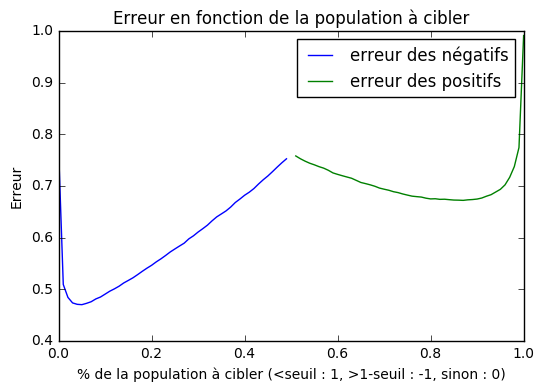

In [9]:
clf.fit(X_unique,y_unique)
probas = clf.predict_proba(X)[:,0]

populationACibler(probas, y, 0.01)

In [152]:
export_txt(clf, X_test, probaG, probaD)

Score de 0.631355932203

### MLP

In [40]:
%%time 
param_grid = {"activation" : ['identity', 'logistic', 'tanh', 'relu'],
             "solver" : ['lbfgs', 'sgd', 'adam'], 
              "alpha" : [0.0001, 0.001, 0.01, 0.1, 1]
             }

GSCV = GridSearchCV(MLPClassifier(), param_grid, scoring=challengeScore, cv = 5)
GSCV.fit(X_train, y_train)
print(GSCV.best_score_ )
print(GSCV.best_estimator_)


C:\Users\Mohamed\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Mohamed\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Mohamed\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Mohamed\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Mohamed\Anaconda3\lib\site-packages\skl

1.11458333333
MLPClassifier(activation='logistic', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Wall time: 11h 28min 7s


In [54]:
GSCV.cv_results_

joblib.dump(GSCV, 'GridMLP.pkl') 

['GridMLP.pkl']

proba à cibler -1  : 0.02 et moins
pourcentage à cibler 1 : 0.95 et plus
erreur : 0.1277712952158693
proba à cibler -1  : 0.05 et moins
pourcentage à cibler 1 : 0.96 et plus
erreur : 0.12329832749902761
proba à cibler -1  : 0.01 et moins
pourcentage à cibler 1 : 0.97 et plus
erreur : 0.12096460521197977
proba à cibler -1  : 0.03 et moins
pourcentage à cibler 1 : 0.98 et plus
erreur : 0.11396343835083625
proba à cibler -1  : 0.01 et moins
pourcentage à cibler 1 : 0.97 et plus
erreur : 0.10229482691559705
[ 0.024  0.966]
Wall time: 12.6 s


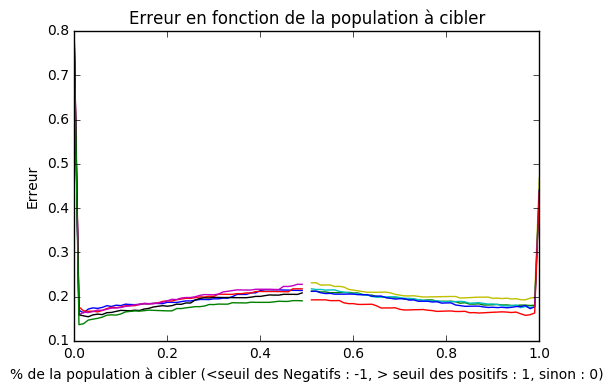

In [85]:
%%time 
#{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
mlp = MLPClassifier(hidden_layer_sizes=100, activation= 'relu', alpha=0.001, solver= "adam", learning_rate_init=0.01, \
                    early_stopping=False, validation_fraction=0.4, beta_1=0.1, beta_2=0.9999)

print(cross_valid_seuil(mlp, X_unique, y_unique))

In [86]:
export_txt(mlp, X_test, 0.024, 0.966)

In [53]:
probas = clf2.predict_proba(X_test)[:,0]
y_opt_test = [1 if proba < 0.02 else -1 if proba > 1-0.02 else 0 for proba in probas]
np.savetxt('y_pred.txt', y_opt_test, fmt='%d')

### XGBOOST

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

gbm = xgb.XGBClassifier()
gbm_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [10, 15,50],
    'max_depth': [5, 15, 50,100],
}

grid = GridSearchCV(gbm, gbm_params, scoring=calcul_score_ciblé,cv=5,verbose=1,n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_score_ )
print(grid.best_estimator_)
print (grid.best_params_)

C:\Users\Mohamed\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


### SVM
Score de 0.147 avec c=10000 et kernel = rbf

In [71]:
X_unique, y_unique = subset_KNN(X, y, X_test, k=10)

In [72]:
print(X_unique.shape)

(40780, 122)


In [79]:
svm = SVC(probability=True, kernel='rbf')
svm_params = {
    'C': [4,5,6],
    'gamma': [1.3, 1.4, 1.5, 1.6],
}

grid = GridSearchCV(svm, svm_params, cv=4,verbose=1,n_jobs=2)

grid.fit(X_unique, y_unique)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed: 392.5min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'gamma': [1.3, 1.4, 1.5, 1.6], 'C': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [81]:
print(1-grid.best_score_ )
print (grid.best_params_)

0.0203776360961
{'gamma': 1.4, 'C': 5}


proba à cibler -1  : 0.09 et moins
pourcentage à cibler 1 : 0.88 et plus
erreur : 0.08288376655223148
proba à cibler -1  : 0.11 et moins
pourcentage à cibler 1 : 0.89 et plus
erreur : 0.07781592283799248
proba à cibler -1  : 0.09 et moins
pourcentage à cibler 1 : 0.94 et plus
erreur : 0.08934118031714892
proba à cibler -1  : 0.13 et moins
pourcentage à cibler 1 : 0.93 et plus
erreur : 0.08386463952918097
proba à cibler -1  : 0.11 et moins
pourcentage à cibler 1 : 0.93 et plus
erreur : 0.08222985123426517
[[ 0.09  0.11  0.09  0.13  0.11]
 [ 0.09  0.11  0.09  0.13  0.11]]


array([ 0.106,  0.106])

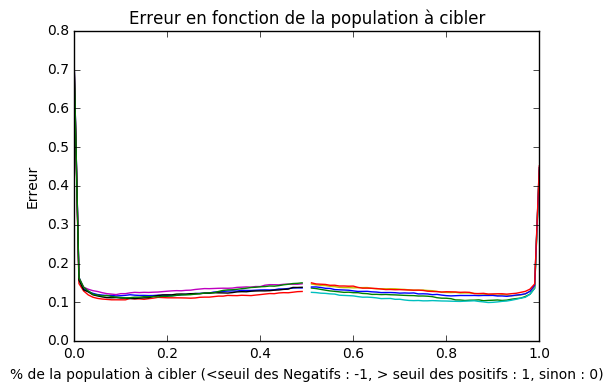

In [ ]:
svm = SVC(probability=True, C=5, kernel='rbf', gamma = 1.4, random_state=40)
cross_valid_seuil(svm, X_unique, y_unique)

In [85]:
svm.fit(X_unique, y_unique)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1.4, kernel='rbf',
  max_iter=-1, probability=True, random_state=40, shrinking=True,
  tol=0.001, verbose=False)

In [86]:
export_txt(svm, X_test, 0.104, 0.906)

##### n_neigbours = 3
Unique : 

C = 20000, gamma = 1, pop = 0.13 : 0.089

C = 20000, gamma = 0.5, pop = 0.15 : 0.0974

C = 20000, gamma = 0.75, pop = 0.15 : 0.0908

C = 20000, gamma = 1.5, pop = 0.09 : 0.0864

C = 20000, gamma = 1.75, pop = 0.11 : 0.0859

not unique : 

C = 20000, gamma = 1.75, pop = 0.08 : 0.0677

##### n_neigbours = 2

C = 20000, gamma = 1.75, pop = 0.06 : 0.0806


In [134]:
%%time
clf = SVC(probability=True, C = 20000, gamma = 1.75)
clf.fit(X_unique, y_unique)

Wall time: 2min 10s


In [7]:
X_unique, y_unique = subset_KNN(X, y, X_test, k=3 )
svm = SVC(probability=True, kernel='rbf', C=1.75, gamma=0.01)

SVC(C=1.75, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

proba à cibler -1  : 0.09 et moins
pourcentage à cibler 1 : 0.94 et plus
erreur : 0.3714507973551147
proba à cibler -1  : 0.11 et moins
pourcentage à cibler 1 : 0.88 et plus
erreur : 0.38759237650719564
proba à cibler -1  : 0.13 et moins
pourcentage à cibler 1 : 0.87 et plus
erreur : 0.38078568650330613
proba à cibler -1  : 0.15 et moins
pourcentage à cibler 1 : 0.89 et plus
erreur : 0.3309996110462855
proba à cibler -1  : 0.17 et moins
pourcentage à cibler 1 : 0.82 et plus
erreur : 0.36581096849474914


array([ 0.13,  0.13])

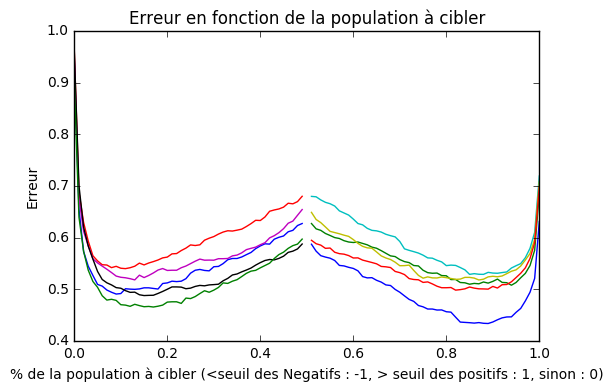

In [10]:
GridSearchCV()
cross_valid_seuil(svm, X_unique, y_unique)

### Random Forest

Erreur minimum : 0.384016973125884
pourcentage à cibler : les 0.35 à plus haute proba
Wall time: 25.1 s


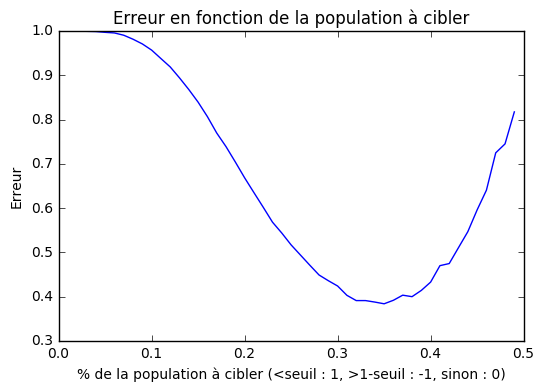

In [38]:
%%time 
rfc = RandomForestClassifier(n_estimators=200 )

X_train, X_test, y_train, y_test = train_test_split(X_unique, y_unique, test_size=0.33, random_state=42)
#print(np.mean(cross_val_score(rfc, X_unique, y_unique, cv=5, scoring=challengeScore)))
rfc.fit(X_train, y_train)
probas = rfc.predict_proba(X_test)[:,0]
populationACibler(probas, y_test, pas = 0.01)

In [33]:
probas = rfc.predict_proba(X_test)[:,0]
y_opt_test = [1 if proba < 0.20 else -1 if proba > 1-0.20 else 0 for proba in probas]
np.savetxt('y_pred.txt', y_opt_test, fmt='%d')

### Mean probas SVM et MLP 

test avec un dataset de validation : 

Erreur minimum : 0.09673518742442563
pourcentage à cibler : les 0.19 à plus haute proba



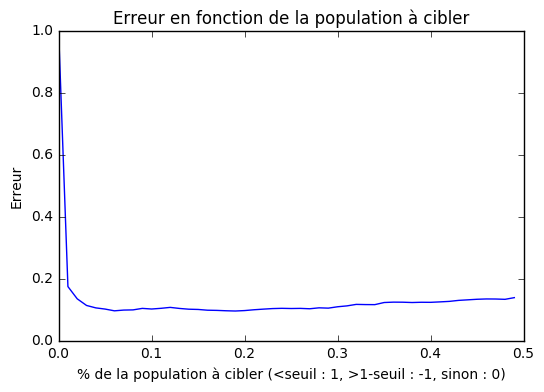

In [176]:
meanProbs = np.mean(probs, axis = 0)
populationACibler(meanProbs, y_test, pas = 0.01)
print()

In [185]:
print(X_test.shape)
probs = np.zeros((2, X_test.shape[0]))
probs[0,:] = svm.predict_proba(X_test)[:,0]
probs[1,:] = mlp.predict_proba(X_test)[:,0]

(8496, 122)


In [186]:
meanProbs = np.mean(probs, axis = 0)

In [197]:
y_opt_test = [1 if proba < 0.05 else -1 if proba > 1-0.05 else 0 for proba in meanProbs]
np.savetxt('y_pred.txt', y_opt_test, fmt='%d')

### Boosting 

In [ ]:
%%time 
from sklearn.ensemble import AdaBoostClassifier

X_unique, y_unique = subset_KNN(X, y, X_test, k=3)

ada = AdaBoostClassifier(base_estimator=SVC(probability=True, C = 100, gamma = 1.5), n_estimators=5)
ada.fit(X_unique, y_unique)

In [89]:
new_X = np.zeros([X_uniquenique, 5])

mlp = MLPClassifier()
mlp.fit(X_unique, y_unique)
mlp.predict_probas(X)

TypeError: only length-1 arrays can be converted to Python scalars

In [40]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(base_estimator=MLPClassifier(), n_estimators=5)
ada.fit(X_unique, y_unique)

ValueError: MLPClassifier doesn't support sample_weight.